In [1]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import seaborn as sns

import plotly
import plotly.figure_factory as ff

import statsmodels.api as sm
import scipy.stats

In [2]:
matplotlib.rcParams['figure.figsize'] = 14, 6 
plt.style.use('tableau-colorblind10')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
#pgf_with_rc_fonts = {"pgf.texsystem": "pdflatex"}
#matplotlib.rcParams.update(pgf_with_rc_fonts)
sns.set_palette(['#003f5c', '#58508d', '#bc5090', '#ff6361', '#ffa600'])

In [3]:
df = pd.read_csv('../data/cleaned/cleaned_data.csv', parse_dates=[0], 
                 dtype={'event_count': int, 'injuries_direct': int,
                        'injuries_indirect': int, 'deaths_direct': int,
                        'deaths_indirect': int, 'parish': 'category', 
                        'region': 'category'})
df['date'] = df.date.dt.to_period('M')

# Only look until 2018 since 2019 is not over
df = df[df.date.dt.year < 2019]
df.head()

,date,parish,region,lat,lon,fips,event_count,injuries_direct,injuries_indirect,deaths_direct,deaths_indirect,damage_property,highest_daily_total_precip,total_precip,avg_temp,mean_max_temp,mean_min_temp
0,1952-04,Acadia,Southwest,30.291497,-92.411037,22001,1,0,0,0,0,250000.0,3.410,8.560,63.9,74.5,53.2
1,1952-05,Acadia,Southwest,30.291497,-92.411037,22001,0,0,0,0,0,0.0,4.425,6.540,73.9,84.6,63.2
2,1952-06,Acadia,Southwest,30.291497,-92.411037,22001,0,0,0,0,0,0.0,0.795,1.820,82.3,92.5,72.1
3,1952-07,Acadia,Southwest,30.291497,-92.411037,22001,0,0,0,0,0,0.0,3.425,10.530,81.9,90.5,73.3
4,1952-08,Acadia,Southwest,30.291497,-92.411037,22001,0,0,0,0,0,0.0,0.565,1.375,82.4,91.4,73.3


In [4]:
storm_df = pd.read_csv('../data/cleaned/event_type_data.csv', parse_dates=[0])
storm_df['date'] = storm_df.date.dt.to_period('M')
storm_df.head()

,date,parish,region,fips,event_type,event_count,injuries_direct,injuries_indirect,deaths_direct,deaths_indirect,damage_property
0,1950-02,Bienville,Northwest,22013,Tornado,1,0,0,0,0,250000.0
1,1950-02,Bossier,Northwest,22015,Tornado,1,37,0,9,0,250000.0
2,1950-02,Caddo,Northwest,22017,Tornado,1,40,0,9,0,250000.0
3,1950-02,Claiborne,Northwest,22027,Tornado,1,10,0,5,0,250000.0
4,1950-02,De Soto,Northwest,22031,Tornado,2,0,0,0,0,500000.0


# Temperature

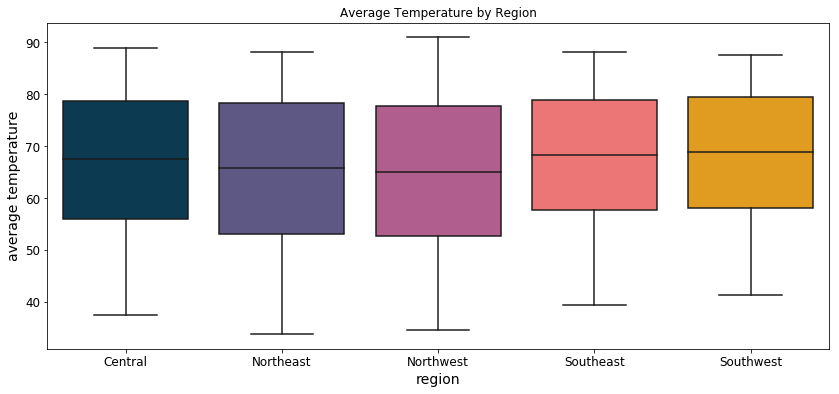

In [5]:
sns.boxplot(x='region', y='avg_temp', data=df)
plt.ylabel('average temperature')
plt.title('Average Temperature by Region');

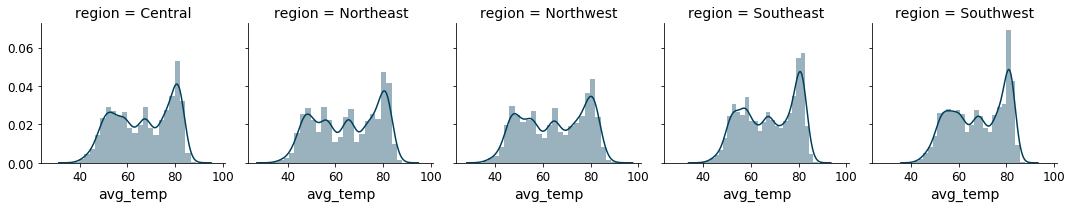

In [6]:
g = sns.FacetGrid(df, col='region')
g.map(sns.distplot, 'avg_temp');

In [7]:
# Standard deviation for average temperature
df.groupby('region')[['avg_temp']].std()

,avg_temp
region,
Central,12.112310
Northeast,13.247908
Northwest,13.245456
Southeast,11.369583
Southwest,11.277076


### Testing for regional differences

Null hypothesis: Northern regions and Southern regions have the same average temperatures.  
Alternative hypothesis: Northern regions have lower average temperatures than Southern regions.  
Significance level: 0.05

In [8]:
northern_temp = df[(df.region == 'Northeast') | (df.region == 'Northwest')]['avg_temp']
southern_temp = df[(df.region == 'Southeast') | (df.region == 'Southwest')]['avg_temp']

scipy.stats.ttest_ind(northern_temp, southern_temp, equal_var=False)

Ttest_indResult(statistic=-25.290084021829696, pvalue=5.456941859278744e-140)

The null hypothesis is rejected, which suggests that Northern regions have slightly lower average temperatures than Southern regions. There is also slightly more variability in Northern regions.

### Three outliers for Northeast

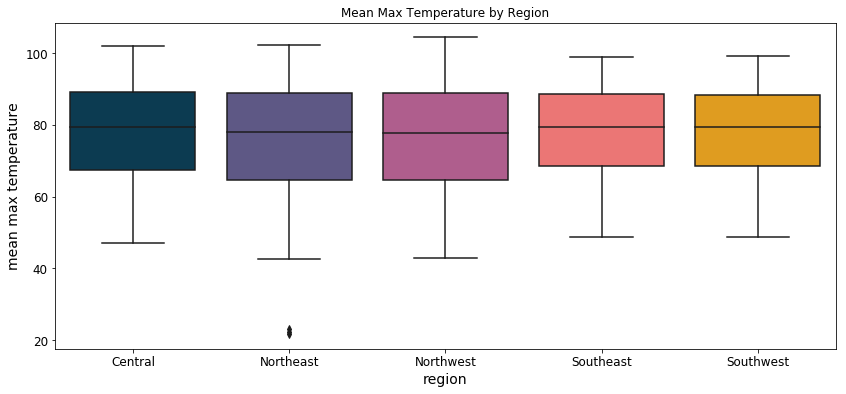

In [ ]:
sns.boxplot(x='region', y='mean_max_temp', data=df)
plt.ylabel('mean max temperature')
plt.title('Mean Max Temperature by Region');

In [ ]:
g = sns.FacetGrid(df, col='region')
g.map(sns.distplot, 'mean_max_temp');

- After further inspection, the mean max temperature is lower than than the mean min temperature.
- Assume accidental Celsius unit and convert to Fahrenheit

In [ ]:
df[df.mean_max_temp < 40]

In [ ]:
# Conversion from Celsius to Fahrenheit
df.loc[[7433, 7438, 7504], 'mean_max_temp'] = df.loc[[7433, 7438, 7504], 'mean_max_temp'] \
                                                * 1.8 + 32

In [ ]:
sns.boxplot(x='region', y='mean_min_temp', data=df)
plt.ylabel('mean min temperature')
plt.title('Mean Min Temperature by Region');

In [ ]:
g = sns.FacetGrid(df, col='region')
g.map(sns.distplot, 'mean_min_temp');

# Precipitation
- There are many outliers, but they are likely attributed to rainy/hurricane seasons.

In [ ]:
sns.boxplot(x='region', y='total_precip', data=df)
plt.ylabel('total monthly precipitation')
plt.title('Total Monthly Precipitation by Region');

In [ ]:
g = sns.FacetGrid(df, col='region')
g.map(sns.distplot, 'total_precip');

In [ ]:
# Standard deviation for total monthly precipitation
df.groupby('region')[['total_precip']].std()

### Testing for regional differences

Null hypothesis: Northern regions and Southern regions have the same amounts of total monthly precipitation.  
Alternative hypothesis: Northern regions have lower amounts of total monthly precipitation compared to Southern regions.  
Significance level: 0.05

In [ ]:
northern_prec = df[(df.region == 'Northeast') | (df.region == 'Northwest')]['total_precip']
southern_prec = df[(df.region == 'Southeast') | (df.region == 'Southwest')]['total_precip']

scipy.stats.ttest_ind(northern_prec, southern_prec, equal_var=False)

The null hypothesis is rejected, which suggests that Northern regions have slightly lower amounts of total monthly precipitation compared to Southern regions. 

In [ ]:
sns.boxplot(x='region', y='highest_daily_total_precip', data=df)
plt.ylabel('highest daily total precipitation')
_ = plt.title('Highest Daily Total Precipitation by Region')

In [ ]:
g = sns.FacetGrid(df, col='region')
g.map(sns.distplot, 'highest_daily_total_precip');

# Total Yearly Event Count, Deaths, Injuries, and Property Damage
- There is an increasing trend in number of storm events with potentially interesting peaks during 1973-1975, 1983-1985, 2008, 2011, and 2015-2018. 
- The spikes in property damage and deaths were in 2005 when Hurricane Katrina devastated South Louisiana. 
- The second highest peak in property damage was in 2016 when there was a 1000-year flood in Central Louisiana. 
- Death count was generally low.

In [ ]:
year_resample = df.set_index('date').resample('Y').sum()

fig, ax = plt.subplots()
year_resample['event_count'].plot(ax=ax, label='event count')
ax.set_ylabel('count')
ax.set_ylim(0, 1300)

# Combine indirect and direct statistics for deaths and injuries
deaths = year_resample.deaths_direct + year_resample.deaths_indirect
injuries = year_resample.injuries_direct + year_resample.injuries_indirect

deaths.plot(ax=ax, color='red', linestyle=':', label='deaths')
injuries.plot(ax=ax, color='orange', linestyle=':', label='injuries')

ax2 = ax.twinx()
year_resample['damage_property'].plot(ax=ax2, color='green', linestyle=':', logy=True, 
                                      label='property damage')
ax2.set_ylabel('property damage (log10 $)')

plt.title('Total Yearly Event Count, Deaths, Injuries, and Property Damage in Louisiana')
# Combine legends
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2);

## This leads me to ask the following questions:  
- What are the most common storm event types?
- Which event types have resulted in the most amount of property damage, injuries, and deaths?
- What could be the reason(s) for such a drastic change in the number of storm events from 1950 to now? 

### What are the most common storm event types?

In [ ]:
storm_df.groupby('event_type')[['event_count']].sum().sort_values(by='event_count', 
                                                                  ascending=False)[:5] \
                                                     .plot(kind='bar')
plt.xticks(rotation='horizontal')
plt.ylabel('count')
plt.title('Most Common Storm Events');

### Which event types have resulted in the most amount of property damage, injuries, and deaths?

In [ ]:
# Key for color consistency for storm events
colors = ["#69ef7b", # drought
          "#344b46", # flash flood
          "#64d4fd", # flood
          "#7a2f9b", # funnel cloud
          "#048ad1", # hail
          "#fbacf6", # heat
          "#523d6e", # high wind
          "#93d5a9", # hurricane (typhoon)
          "#0b6d33", # ice storm
          "#b1d34f", # lightning
          "#d5082d", # storm surge/tide
          "#f4d16a", # strong wind
          "#2D2DB4", # thunderstorm wind
          "#eb957f", # tornado
          "#fe8f06", # tropical storm
          "#75887b", # winter storm
          "#d5d0fa"] # winter weather

In [ ]:
# Sum up all of property damage by event type
prop_dmg = storm_df.groupby('event_type')[['damage_property']] \
                   .sum() \
                   .sort_values(by='damage_property', 
                                ascending=False)

# Sum up other event types and label as Other
other = prop_dmg['Thunderstorm Wind':].sum()
prop_dmg = prop_dmg[:5]
prop_dmg.loc['Other'] = other

In [ ]:
fig, ax = plt.subplots(1, 2)

# Pie chart
colors = ["#d5082d", "#93d5a9", "#64d4fd", "#344b46", "#eb957f", '#6e6e6e']
prop_dmg['damage_property'].plot(ax=ax[0], kind='pie', autopct='%1.1f%%',
                                colors=colors)
ax[0].set_title('Overall Percentage of Property Damage by Event Type')
ax[0].set_ylabel(None)

# Bar
prop_dmg.plot(ax=ax[1], kind='bar', color='green')

ax[1].set_xticklabels(prop_dmg.index, rotation=50)
ax[1].set_ylabel('total sum (trillions $)')
ax[1].set_title('Top 5 Events Resulting in Highest Amounts of Property Damage', pad=20.5)

fig.subplots_adjust(left=.5, right=1.5);

In [ ]:
# Sum up all indirect and direct injuries by event type
injuries_df = storm_df.groupby('event_type')[['injuries_indirect', 'injuries_direct']].sum()

# Combine indirect and direct injuries
injuries_df['total_injuries'] = injuries_df['injuries_indirect'] + injuries_df['injuries_direct']
injuries_df = injuries_df.sort_values(by='total_injuries', ascending=False)

# Sum up other event types and label as Other
other = injuries_df['Tropical Storm':].sum()
injuries = injuries[['total_injuries']][:5]
injuries.loc['Other'] = other

In [ ]:
fig, ax = plt.subplots(1, 2)

colors = ["#eb957f", "#2D2DB4", "magenta", "#b1d34f", "#344b46", '#6e6e6e']
injuries['total_injuries'].plot(ax=ax[0], kind='pie', autopct='%1.1f%%',
                                colors=colors)
ax[0].set_title('Overall Percentage of Injuries by Event Type')
ax[0].set_ylabel(None)

injuries.plot(ax=ax[1], kind='bar', color='orange')
ax[1].set_xticklabels(injuries.index, rotation=60)
ax[1].set_ylabel('total count')
ax[1].set_title('Top 5 Events Resulting in Most Injuries')

fig.subplots_adjust(left=.5, right=1.5);

#### The significantly high amount of deaths in hurricanes is due to Hurricane Katrina in 2005

In [ ]:
# Sum up all indirect and direct deaths by event type
deaths_df = storm_df.groupby('event_type')[['deaths_indirect', 'deaths_direct']].sum()

# Combine indirect and direct deaths
deaths_df['total_deaths'] = deaths_df['deaths_indirect'] + deaths_df['deaths_direct']

deaths = deaths_df[['total_deaths']].sort_values(by='total_deaths', ascending=False)

other = deaths['Flash Flood':].sum()
deaths = deaths[:5]
deaths.loc['Other'] = other

In [ ]:
# Check if any deaths besides Katrina for October 2008
oct08_dir_deaths = storm_df[(storm_df.date == '2005-08') & 
                            (storm_df.event_type != 'Hurricane (Typhoon)')] \
                             ['deaths_direct'].sum()
oct08_indir_deaths = storm_df[(storm_df.date == '2005-08') & 
                              (storm_df.event_type != 'Hurricane (Typhoon)')] \
                               ['deaths_indirect'].sum()

print('Direct Deaths in October 2008 besides Katrina:', oct08_dir_deaths)
print('Indirect Deaths in October 2008 besides Katrina:', oct08_indir_deaths)

In [ ]:
# Filter out October 2008
# Sum up all indirect and direct deaths by event type
no_katrina = storm_df[(storm_df.date != '2005-08')].groupby('event_type') \
             [['deaths_indirect', 'deaths_direct']].sum()

# Combine indirect and direct deaths
no_katrina['total_deaths'] = no_katrina['deaths_indirect'] + no_katrina['deaths_direct']

no_katrina = no_katrina[['total_deaths']].sort_values(by='total_deaths', 
                                                      ascending=False)

other = no_katrina['Excessive Heat':].sum()
no_katrina = no_katrina[:5]
no_katrina.loc['Other'] = other

Note the scale difference in the y-axis

In [ ]:
fig, ax = plt.subplots(1, 2)

# With Katrina
deaths.plot(ax=ax[0], kind='bar', color='red')
ax[0].set_xticklabels(deaths.index, rotation=60)
ax[0].set_ylabel('count')
ax[0].set_title('Top 5 Events Resulting in Most Deaths')

# Without Katrina
no_katrina.plot(ax=ax[1], kind='bar', color='red')
ax[1].set_xticklabels(no_katrina.index, rotation=60)
ax[1].set_ylabel('count')
ax[1].set_title('Top 5 Events (Excluding Hurricane Katrina) Resulting in Most Deaths');

In [ ]:
fig, ax = plt.subplots(1, 2)

# With Katrina
colors = ["#93d5a9", "#eb957f", "#fbacf6", "#2D2DB4", "#b1d34f", '#6e6e6e']
deaths['total_deaths'].plot(ax=ax[0], kind='pie', autopct='%1.1f%%', colors=colors)
ax[0].set_title('Overall Percentage of Deaths by Event Type')
ax[0].set_ylabel(None)

# Without Katrina
colors = ["#eb957f", "#fbacf6", "#2D2DB4", "#b1d34f", "#344b46", '#6e6e6e']
no_katrina['total_deaths'].plot(ax=ax[1], kind='pie', autopct='%1.1f%%', colors=colors)
ax[1].set_title('Overall Percentage of Deaths by Event Type (Without Katrina)')
ax[1].set_ylabel(None)

fig.subplots_adjust(left=.5, right=1.4);

### What could be the reason(s) for such a drastic change in the number of storm events from 1950 to now?

[Source](https://www.ncdc.noaa.gov/stormevents/details.jsp):  
1. Tornado: From 1950 through 1954, only tornado events were recorded.

2. Tornado, Thunderstorm Wind and Hail: From 1955 through 1992, only tornado, thunderstorm wind and hail events were keyed from the paper publications into digital data. From 1993 to 1995, only tornado, thunderstorm wind and hail events have been extracted from the Unformatted Text Files.

3. All Event Types (48 from Directive 10-1605): From 1996 to present, 48 event types are recorded as defined in [NWS Directive 10-1605](https://www.ncdc.noaa.gov/stormevents/pd01016005curr.pdf).  

In [ ]:
storm_df[['date', 'event_count']].groupby('date').sum() \
                                 .plot()
plt.ylabel('count')
_ = plt.title('Storm Event Count (1950-2018)')

Note: For modeling purposes, it will be best to only use data from 1996 to present.

In [ ]:
# Filter for 1996-2018, only take date and event_count columns
# Group by date and sum, then plot
storm_df[storm_df.date.dt.year > 1995][['date', 'event_count']].groupby('date').sum() \
                                                               .plot()
plt.ylabel('count')
_ = plt.title('Storm Event Count (1996-2018)')

# Yearly Event Count by Region
- Northwest Louisiana has consistently had the most number of storm events (with some exceptions) while Central Louisiana generally has had the least. 
- The trends are generally similar among all regions with Northwest Louisiana being the general exception. 

In [ ]:
# New DataFrame with only date, region, event_count
region_event = df[['date', 'region', 'event_count']].set_index('date') 
# Filter for 1996 to 2018
region_event = region_event[region_event.index.year > 1995].groupby('region') \
                                                           .resample('Y') \
                                                           .sum() \
                                                           .unstack('region')

colors = ['#003f5c', '#58508d', '#bc5090', '#ff6361', '#ffa600']
fig, ax = plt.subplots()
for col, color in zip(region_event.columns, colors):
    region_event[col].plot(c=color, linestyle=':', alpha=0.90)

# Get average for all regions per year
means = region_event.unstack().groupby('date').mean()
plt.plot(means, c='k')

ax.set_ylim(0, 450)
plt.title('Yearly Event Count by Region in Louisiana (1996-2018)')
plt.ylabel('event count')
_ = plt.legend(['Central', 'Northeast', 'Northwest', 'Southeast', 'Southwest', 'Average'])

## This leads me to ask the following questions:
- It is surprising that Northwest Louisiana consistently has the most number of storm events. What type of storm events are common for this region?
- What happened in Southeast Louisiana in 2002 and 2004?
- What happened in Northeast Louisiana in 2006?

### What type of storm events are common for Northwest Louisiana?

In [ ]:
# Group by event type and only take event_count column and sum
storm_df[(storm_df.region == 'Northwest') & 
         (storm_df.date.dt.year > 1995)].groupby('event_type')[['event_count']] \
                                        .sum() \
                                        .sort_values(by='event_count', 
                                                     ascending=False)[:5] \
                                        .plot(kind='bar')
plt.ylabel('count')
plt.xticks(rotation='horizontal')
_ = plt.title('Most Common Storm Events in Northwest Louisiana')

### What happened in Southeast Louisiana in 2002?

In [ ]:
# Filter for Southeast region and 2002 year
# Group by event type and only take event_count column
# Sum and sort descending
storm_df[(storm_df.date.dt.year == 2002) & 
         (storm_df.region == 'Southeast')].groupby('event_type')[['event_count']] \
                                          .sum() \
                                          .sort_values(by='event_count', 
                                                       ascending=False)

#### Of interest:
- **Winter storms** in January
    - [Snow hits and unpracticed South and shuts it down](https://www.nytimes.com/2002/01/04/us/snow-hits-an-unpracticed-south-and-shuts-it-down.html)
- Relatively high number of **lightning** events in July
- High number of **thunderstorm winds** especially in July, but also noteable events in April and December. 
- **Tropical storms** in August and September
    - August:
        - 5th - Tropical Storm Bertha makes landfall on Boothville as a minimal tropical storm with wind speeds of 40 mph (64 km/h) and a minimum pressure of 1,008 mbar (29.8 inHg), moving across Louisiana as a weakening system before moving back into the Gulf of Mexico on August 7. The storm drops scattered rainfall across the state, peaking southwest of Franklinton at 10.25 in (26.0 cm). Streets were flooded by the heavy rainfall in Slidell. In St. Tammany Parish, surface runoff from flash flooding causes some rivers to exceed flood stage. Damage in Louisiana totaled to \\$150,000 (2002 USD, \\$180,000 2008 USD).
    - September:
        - 5th - Tropical Storm Fay develops offshore the Louisiana coast before making landfall in Texas as a moderate tropical storm. West of Cameron, Fay causes a storm surge as high as 2.5 ft (0.76 m), resulting in minor beach erosion and coastal highway flooding. Tropical Storm Fay's outer rainbands drop light rainfall over eastern and southern portions of the state, peaking at 4.64 in (11.8 cm) in Grand Isle. Prior to making landfall, a tropical storm warning is issued for western parts of Louisiana east to Intracoastal City.
        - 14th - Tropical Storm Hanna makes landfall near the mouth of the Mississippi River as a moderate tropical storm with winds of 50 mph (80 km/h), before subsequently making landfall on the border between Alabama and Mississippi. Despite making landfall on Louisiana, as a result of convection displaced east of the center, the state receives primarily minimal effects from Hanna. No significant flooding resulted from high tides caused by the storm. Rainfall is confined to extreme eastern portions of the state, where rainfall peaks at 1.72 in (4.4 cm) in Sondeheimer, Louisiana.
        - 26th - Hurricane Isidore makes landfall just west of Grand Isle as a Tropical Storm with winds of 65 mph (105 km/h), having significantly weakened after stalling over the Yucatán Peninsula. Rainfall is widespread across the state, peaking at 15.97 in (406 mm) in Metarie. The heavy rains cause the failure of drainage systems, leaving numerous streets flooded. In Terrebonne Parish, 200–300 homes are flooded. The rains also damage large plots of sugar cane crop in Southwest Louisiana.
- **Huricanes** in October
    - 3rd - Hurricane Lili made landfall on the morning of October 3 near Intracoastal City, as a weakening category 1 hurricane. Wind gusts reaching 120 mph (190 km/h), coupled with over 6 inches (150 mm) of rainfall and a storm surge of 12 feet (3.7 m) caused over \\$790 million (2002 USD) in damage to Louisiana. A total of 237,000 people lost power, and oil rigs offshore were shut down for up to a week. Crops were badly affected, particularly the sugar cane, damage totaled nearly \\$175 million (2002 USD). No direct deaths were reported as early warnings and the compact nature of the storm circumvented major loss of life.
    
[Tropical Storm/Hurricane Source](https://en.wikipedia.org/wiki/List_of_Louisiana_hurricanes_(2000%E2%80%93present))

In [ ]:
colors = ["#344b46", "#64d4fd", '#7a2f9b', '#048ad1', "#523d6e", "#93d5a9", "#b1d34f", "#2D2DB4", 
          "#eb957f", "#fe8f06", "#75887b"]

# Filter for Southeast region and 2002 year
# Group by event type and only take event_count column
# Sum then plot
_ = storm_df[(storm_df.date.dt.year == 2002) & 
             (storm_df.region == 'Southeast')].groupby(['date', 'event_type'])[['event_count']] \
                                              .sum() \
                                              .unstack() \
                                              .plot(kind='bar', 
                                                    stacked=True, 
                                                    color=colors)
plt.ylabel('count')
plt.title('Storm Events in Southeast Louisiana (2002)')
_ = plt.legend(['Flash Flood', 'Flood', 'Funnel Cloud', 'Hail', 'High Wind', 
                'Hurricane (Typhoon)', 'Lightning', 'Thunderstorm Wind', 'Tornado', 
                'Tropical Storm', 'Winter Storm'])

### What happened in Southeast Louisiana in 2004?

In [ ]:
# Filter for Southeast region and 2004 year
# Group by event type and only take event_count column
# Sum and sort descending
storm_df[(storm_df.date.dt.year == 2004) & 
         (storm_df.region == 'Southeast')].groupby('event_type')[['event_count']] \
                                          .sum() \
                                          .sort_values(by='event_count', 
                                                       ascending=False)

#### Of interest:
- Relatively high number of **hail** events in February, but also noteable events in April and June
- **Flash floods** mainly in April and May
    - [Stormy weather caused flooding in May over Southeast Louisiana and South Mississippi](https://www.weather.gov/media/lix/E5/2004/lixe5may04.pdf)
- High number of **thunderstorm winds** especially in June, but also in May and November
- **Tropical storms**, **hurricanes**, and **storm surges/tides** in September and October
    - September: Around the time Hurricane Ivan's initial landfall in Alabama, the storm produced wind gusts as strong as 100 mph (160 km/h) at the Southwest Pass of the Mississippi River. In Plaquemines Parish, several school and government building as well as about 100 mobile homes. Additionally, about 50 electrical poles were toppled. About a dozen structure in St. Bernard Parish were damaged. Storm surge flooded several low-lying areas in southeastern Louisiana. About 55,000 customers lost power during the storm. Four people died during evacuation and damage in the state reached roughly \\$7.9 million. Upon the storm's second landfall in Holly Beach resulted in minor coastal flooding, with damage totaling only about \\$15,000. Inland, generally light rainfall was recorded.
    - October: Tropical Storm Matthew caused a storm surge of up to 5.85 ft (1.78 m) in Frenier. The storm surge and waves resulted in significant beach erosion in Grand Isle. Portions of Louisiana experienced significant rainfall, including a peak of 18 inches (460 mm) in Haynesville. In addition, a tornado caused damage to the roof of a trailer in Golden Meadow. Rainfall and storm surge flooded 20 homes in Terrebonne Parish. In addition, several homes in Lafouche Parish experienced flooding, including two with over two feet of water. Numerous homes in Golden Meadow experienced flooding, as well. The flooding also forced the temporary closing of numerous roads across the state, including portions of Route 11 and Interstate 10. Flood waters from the storm cracked a water line in LaPlace, leaving nearly 30,000 residents and many businesses without tap water. The problem was expected to take little time to fix, though residents were advised to boil the water before drinking it. Matthew also left 2,500 people without power for a short period of time. The storm's impact also closed several schools. In all, Matthew caused \\$255,000 in damage (2004 USD).
- **Winter storms** in December
    - [The Great Christmas Eve Storm of 2004](https://www.farmersalmanac.com/the-great-christmas-eve-snow-storm-2004-2246)

[Tropical Storm/Hurricane Source](https://en.wikipedia.org/wiki/List_of_Louisiana_hurricanes_(2000%E2%80%93present))

In [ ]:
colors = ["#344b46", "#7a2f9b", "#048ad1", "#93d5a9", "#b1d34f", "#d5082d", "#2D2DB4", "#eb957f", 
          "#fe8f06", "#75887b"]

# Filter for Southeast region and 20024year
# Group by event type and only take event_count column
# Sum and plot
storm_df[(storm_df.date.dt.year == 2004) & 
         (storm_df.region == 'Southeast')].groupby(['date', 'event_type'])[['event_count']] \
                                          .sum() \
                                          .unstack() \
                                          .plot(kind='bar', 
                                                stacked=True,
                                                color=colors)
plt.ylabel('count')
plt.title('Storm Events in Southeast Louisiana (2004)')
_ = plt.legend(['Flash Flood', 'Funnel Cloud', 'Hail', 'Hurricane (Typhoon)', 'Lightning', 
                'Storm Surge/Tide', 'Thunderstorm Wind', 'Tornado', 'Tropical Storm', 
                'Winter Storm'])

### What happened in Northeast Louisiana in 2006?

In [ ]:
# Filter for Northeast region and 2006 year
# Group by event type and only take event_count column
# Sum and sort descending
storm_df[(storm_df.date.dt.year == 2006) & 
         (storm_df.region == 'Northeast')].groupby('event_type')[['event_count']] \
                                          .sum() \
                                          .sort_values(by='event_count', 
                                                       ascending=False)

#### Of interest:
- High number of **hail** events in February, April, and May
- **Thunderstorm events** throughout the year mainly in March, April, May, July, August, October, and November
- **Heat** in July
- **Drought** in October
    - [2006-08 Southeastern United States Drought](https://en.wikipedia.org/wiki/2006%E2%80%9308_Southeastern_United_States_drought)

In [ ]:
colors = ["#69ef7b", "#344b46", "#7a2f9b", "#048ad1", "#fbacf6", "#0b6d33", "#b1d34f", "#f4d16a", 
          "#2D2DB4", "#eb957f", "#d5d0fa"]

# Filter for Northeast region and 2006 year
# Group by event type and only take event_count column
# Sum and plot
storm_df[(storm_df.date.dt.year == 2006) & 
         (storm_df.region == 'Northeast')].groupby(['date', 'event_type'])[['event_count']] \
                                          .sum() \
                                          .unstack() \
                                          .plot(kind='bar',
                                                stacked=True, 
                                                color=colors)
plt.ylabel('count')
plt.title('Storm Events in Southeast Louisiana (2006)')
_ = plt.legend(['Drought', 'Flash Flood', 'Funnel Cloud', 'Hail', 'Heat', 'Ice Storm', 'Lightning', 'Strong Wind',
                'Thunderstorm Wind', 'Tornado', 'Winter Weather'])

# Map Visualization

In [ ]:
def plot(year, parameter):
    df_sample = df[df.date.dt.year == year]
    values = df_sample[parameter].tolist()
    fips = df_sample['fips'].tolist()
    
    if parameter in ['event_count', 'deaths_indirect', 'deaths_direct', 'injuries_indirect',
                     'injuries_direct', 'damage_property']:
        endpts = list(np.mgrid[1:max(values):6j])
    else:
        endpts = list(np.mgrid[min(values):max(values):6j])
        
    colorscale = ['#fff7fb', '#ece7f2', '#d0d1e6', '#a6bddb', '#74a9cf', '#3690c0', 
                  '#0570b0', '#045a8d', '#023858']
    fig = ff.create_choropleth(
        fips=fips, values=values, scope=['Louisiana'], show_state_data=True,
        colorscale=colorscale, binning_endpoints=endpts, 
        round_legend_values=True,
        plot_bgcolor='rgb(229,229,229)',
        paper_bgcolor='rgb(229,229,229)',
        legend_title=parameter+' by Parish',
        county_outline={'color': 'rgb(0,0,0)', 'width': 0.5},
        #exponent_format=True,
    )
    fig.layout.template = None
    fig.show()
    
    
_ = interact(plot, year=range(1950, 2019), parameter=df.columns.tolist()[6:])